# Recurrent Deep Reinforcement Learning
***

Typical reinforcement learning (RL) problems assume the environment is a Markov decision process (MDP). Put simply an MDP at any given point in time is in some state $$s_i$$ and has some space of actions $$\mathcal{A}$$ which are allowed to be taken. A basic assumption of an MDP is that the dynamics of the system depend only uppon the current state and not on the path which brought you to that point.

This is often not a reasonable assumption since many real world environments either do not show all of state, or show it incorrectly (such as measurement errors) or have explicit dependency on previous states. These are all known as partially observed markov decision processes (POMDPs). It can be realized that all POMDPs can be thought of as a complete state in a MDP but which only partial information is shared in the observations of state provided by the environment.

For the example in the temporal information case, the full state of the MDP is the entire history of actions rewards and states in the episode, but only the last state is presented as an observation.

In this notebook I'm attempting to partially reproduce the results of [Heess et al.](https://arxiv.org/abs/1512.04455) and [Hausknecht and Stone](https://arxiv.org/abs/1507.06527) in which they use recurrent neural networks to remember previous states which can help in many tasks. I'm applying it to the CartPole environment with the velocity information removed from state. This reduces the state to just position information at any given timestep.

I start by implementing a standard DQN network on the full CartPole problem to confirm that it is solved. I then also implement Dueling DQN in which the advantage and value are estimated separately and then combined... Just to compare.

I then show that these networks are incapable of solving the POMDP of "limitedCartPole" with only position information.

Finally I attempt to implement a recurrent DQN network to solve the limited Cartpole problem and manage to achieve some improvement temporarily however the learning is extremely unstable.

In [1]:
import numpy as np
import gym
from gym import wrappers
from runner import TestRunner
import keras.backend as K

from agents import *
from tasks import *

%matplotlib inline
agent_num = 0

Using TensorFlow backend.


In [2]:
cartPole = gym.make('CartPole-v0')

[2018-03-01 21:20:40,175] Making new env: CartPole-v0


## Standard CartPole

I have implemented DQN and Dueling DQN in separate files /agents/DQN.py and /agents/DuelingDQN.py respectfully if you want to inspect them. It is a pretty standard implementation. Here I run 10 trials of both and compare them

In [3]:
DQNrunner = TestRunner(cartPole, 'DQN', 5000, report_interval=50, print_test=True, runs=10)
DuelingDQNrunner = TestRunner(cartPole, 'DuelingDQN', 5000, report_interval=50, print_test=True, runs=10)

DQNrunner.start()
print ("DQN FINISHED... STARTING DUELING DQN")
DuelingDQNrunner.start()

Starting Run: 0
Episode   50 - Testing  :     9.00
Episode  100 - Testing  :     9.00
Episode  150 - Testing  :     9.40
Episode  200 - Testing  :     9.60
Episode  250 - Testing  :     9.40
Episode  300 - Testing  :     9.20
Episode  350 - Testing  :     9.60
Episode  400 - Testing  :     9.40
Episode  450 - Testing  :    11.60
Episode  500 - Testing  :    13.60
Episode  550 - Testing  :    16.20
Episode  600 - Testing  :    17.20
Episode  650 - Testing  :    27.80
Episode  700 - Testing  :    10.00
Episode  750 - Testing  :     9.00
Episode  800 - Testing  :     9.20
Episode  850 - Testing  :    17.20
Episode  900 - Testing  :    13.20
Episode  950 - Testing  :    13.20
Episode 1000 - Testing  :    15.00
Episode 1050 - Testing  :    28.80
Episode 1100 - Testing  :    29.20
Episode 1150 - Testing  :    24.20
Episode 1200 - Testing  :    33.40
Episode 1250 - Testing  :    32.60
Episode 1300 - Testing  :    27.00
Episode 1350 - Testing  :    34.00
Episode 1400 - Testing  :    41.80
Epis

Episode 1500 - Testing  :   116.60
Episode 1550 - Testing  :    66.20
Episode 1600 - Testing  :    49.00
Episode 1650 - Testing  :   112.20
Episode 1700 - Testing  :    52.00
Episode 1750 - Testing  :    78.60
Episode 1800 - Testing  :    57.20
Episode 1850 - Testing  :    50.40
Episode 1900 - Testing  :    83.20
Episode 1950 - Testing  :    76.00
Episode 2000 - Testing  :    46.60
Episode 2050 - Testing  :    46.60
Episode 2100 - Testing  :   110.60
Episode 2150 - Testing  :    67.60
Episode 2200 - Testing  :    70.20
Episode 2250 - Testing  :    94.00
Episode 2300 - Testing  :    84.80
Episode 2350 - Testing  :    70.00
Episode 2400 - Testing  :    69.20
Episode 2450 - Testing  :   101.00
Episode 2500 - Testing  :    66.60
Episode 2550 - Testing  :    73.40
Episode 2600 - Testing  :    91.20
Episode 2650 - Testing  :   148.40
Episode 2700 - Testing  :   119.60
Episode 2750 - Testing  :   114.60
Episode 2800 - Testing  :   103.20
Episode 2850 - Testing  :   131.20
Episode 2900 - Testi

Episode 3050 - Testing  :    42.40
Episode 3100 - Testing  :    45.20
Episode 3150 - Testing  :    63.20
Episode 3200 - Testing  :    57.20
Episode 3250 - Testing  :    58.20
Episode 3300 - Testing  :    57.60
Episode 3350 - Testing  :   122.60
Episode 3400 - Testing  :   163.20
Episode 3450 - Testing  :   155.80
Episode 3500 - Testing  :   132.60
Episode 3550 - Testing  :   134.60
Episode 3600 - Testing  :   156.00
Episode 3650 - Testing  :   148.40
Episode 3700 - Testing  :   110.20
Episode 3750 - Testing  :    71.80
Episode 3800 - Testing  :   164.80
Episode 3850 - Testing  :   160.00
Episode 3900 - Testing  :   153.20
Episode 3950 - Testing  :   129.20
Episode 4000 - Testing  :   165.60
Episode 4050 - Testing  :   145.60
Episode 4100 - Testing  :   132.80
Episode 4150 - Testing  :   152.00
Episode 4200 - Testing  :   149.80
Episode 4250 - Testing  :   154.80
Episode 4300 - Testing  :   141.00
Episode 4350 - Testing  :   118.80
Episode 4400 - Testing  :   144.60
Episode 4450 - Testi

Episode 4600 - Testing  :   181.40
Episode 4650 - Testing  :   200.00
Episode 4700 - Testing  :   184.20
Episode 4750 - Testing  :   192.80
Episode 4800 - Testing  :   169.60
Episode 4850 - Testing  :   151.40
Episode 4900 - Testing  :   192.40
Episode 4950 - Testing  :   140.80
Episode 5000 - Testing  :   195.60
Starting Run: 7
Episode   50 - Testing  :    49.00
Episode  100 - Testing  :    37.00
Episode  150 - Testing  :    23.00
Episode  200 - Testing  :    29.40
Episode  250 - Testing  :    23.60
Episode  300 - Testing  :    14.80
Episode  350 - Testing  :    10.60
Episode  400 - Testing  :     9.60
Episode  450 - Testing  :     9.00
Episode  500 - Testing  :     9.20
Episode  550 - Testing  :     9.00
Episode  600 - Testing  :     9.60
Episode  650 - Testing  :     9.60
Episode  700 - Testing  :    10.20
Episode  750 - Testing  :     8.80
Episode  800 - Testing  :    13.20
Episode  850 - Testing  :     9.20
Episode  900 - Testing  :    16.40
Episode  950 - Testing  :    14.80
Epis

Episode 1050 - Testing  :    93.80
Episode 1100 - Testing  :    39.80
Episode 1150 - Testing  :    91.00
Episode 1200 - Testing  :   147.80
Episode 1250 - Testing  :   114.20
Episode 1300 - Testing  :   167.00
Episode 1350 - Testing  :   191.80
Episode 1400 - Testing  :   190.60
Episode 1450 - Testing  :   197.80
Episode 1500 - Testing  :   185.60
Episode 1550 - Testing  :   189.00
Episode 1600 - Testing  :   101.60
Episode 1650 - Testing  :   166.00
Episode 1700 - Testing  :   200.00
Episode 1750 - Testing  :   146.20
Episode 1800 - Testing  :   106.00
Episode 1850 - Testing  :   167.20
Episode 1900 - Testing  :   156.20
Episode 1950 - Testing  :   165.00
Episode 2000 - Testing  :   129.40
Episode 2050 - Testing  :   164.20
Episode 2100 - Testing  :   143.40
Episode 2150 - Testing  :   156.40
Episode 2200 - Testing  :   195.20
Episode 2250 - Testing  :   125.60
Episode 2300 - Testing  :   141.20
Episode 2350 - Testing  :    83.80
Episode 2400 - Testing  :   126.60
Episode 2450 - Testi

Episode 2550 - Testing  :    83.80
Episode 2600 - Testing  :   200.00
Episode 2650 - Testing  :   117.00
Episode 2700 - Testing  :    97.20
Episode 2750 - Testing  :   112.20
Episode 2800 - Testing  :   159.00
Episode 2850 - Testing  :    79.40
Episode 2900 - Testing  :   106.60
Episode 2950 - Testing  :    50.00
Episode 3000 - Testing  :    43.80
Episode 3050 - Testing  :    32.00
Episode 3100 - Testing  :    34.20
Episode 3150 - Testing  :    19.40
Episode 3200 - Testing  :    16.40
Episode 3250 - Testing  :     8.80
Episode 3300 - Testing  :     9.20
Episode 3350 - Testing  :    34.60
Episode 3400 - Testing  :    23.00
Episode 3450 - Testing  :    10.00
Episode 3500 - Testing  :    21.60
Episode 3550 - Testing  :    36.40
Episode 3600 - Testing  :    19.80
Episode 3650 - Testing  :    59.20
Episode 3700 - Testing  :   143.40
Episode 3750 - Testing  :   120.40
Episode 3800 - Testing  :   188.40
Episode 3850 - Testing  :   200.00
Episode 3900 - Testing  :   200.00
Episode 3950 - Testi

Episode 4100 - Testing  :   200.00
Episode 4150 - Testing  :   200.00
Episode 4200 - Testing  :   200.00
Episode 4250 - Testing  :   199.40
Episode 4300 - Testing  :   195.00
Episode 4350 - Testing  :   200.00
Episode 4400 - Testing  :   200.00
Episode 4450 - Testing  :   200.00
Episode 4500 - Testing  :   200.00
Episode 4550 - Testing  :   200.00
Episode 4600 - Testing  :   200.00
Episode 4650 - Testing  :   200.00
Episode 4700 - Testing  :   200.00
Episode 4750 - Testing  :   200.00
Episode 4800 - Testing  :   199.60
Episode 4850 - Testing  :   200.00
Episode 4900 - Testing  :   130.40
Episode 4950 - Testing  :   190.20
Episode 5000 - Testing  :   200.00
Starting Run: 4
Episode   50 - Testing  :    18.00
Episode  100 - Testing  :    19.00
Episode  150 - Testing  :    16.00
Episode  200 - Testing  :    10.80
Episode  250 - Testing  :    32.00
Episode  300 - Testing  :     8.80
Episode  350 - Testing  :     9.60
Episode  400 - Testing  :    67.40
Episode  450 - Testing  :    58.20
Epis

Episode  550 - Testing  :     8.80
Episode  600 - Testing  :     9.60
Episode  650 - Testing  :     9.20
Episode  700 - Testing  :   136.40
Episode  750 - Testing  :    15.60
Episode  800 - Testing  :     9.00
Episode  850 - Testing  :     9.80
Episode  900 - Testing  :     9.20
Episode  950 - Testing  :     9.40
Episode 1000 - Testing  :    43.60
Episode 1050 - Testing  :    25.80
Episode 1100 - Testing  :   104.80
Episode 1150 - Testing  :   194.60
Episode 1200 - Testing  :    29.00
Episode 1250 - Testing  :    14.80
Episode 1300 - Testing  :    14.20
Episode 1350 - Testing  :    15.20
Episode 1400 - Testing  :    22.40
Episode 1450 - Testing  :    22.40
Episode 1500 - Testing  :     9.60
Episode 1550 - Testing  :     9.40
Episode 1600 - Testing  :     8.80
Episode 1650 - Testing  :     9.60
Episode 1700 - Testing  :     9.20
Episode 1750 - Testing  :    66.00
Episode 1800 - Testing  :   122.80
Episode 1850 - Testing  :    89.60
Episode 1900 - Testing  :   158.40
Episode 1950 - Testi

Episode 2100 - Testing  :   200.00
Episode 2150 - Testing  :   200.00
Episode 2200 - Testing  :   200.00
Episode 2250 - Testing  :   200.00
Episode 2300 - Testing  :   200.00
Episode 2350 - Testing  :   200.00
Episode 2400 - Testing  :   200.00
Episode 2450 - Testing  :   200.00
Episode 2500 - Testing  :   200.00
Episode 2550 - Testing  :   200.00
Episode 2600 - Testing  :   200.00
Episode 2650 - Testing  :   200.00
Episode 2700 - Testing  :   200.00
Episode 2750 - Testing  :   200.00
Episode 2800 - Testing  :   200.00
Episode 2850 - Testing  :   200.00
Episode 2900 - Testing  :   200.00
Episode 2950 - Testing  :   200.00
Episode 3000 - Testing  :   200.00
Episode 3050 - Testing  :   162.20
Episode 3100 - Testing  :   200.00
Episode 3150 - Testing  :    12.20
Episode 3200 - Testing  :   200.00
Episode 3250 - Testing  :     9.20
Episode 3300 - Testing  :     9.00
Episode 3350 - Testing  :   200.00
Episode 3400 - Testing  :   200.00
Episode 3450 - Testing  :    75.60
Episode 3500 - Testi

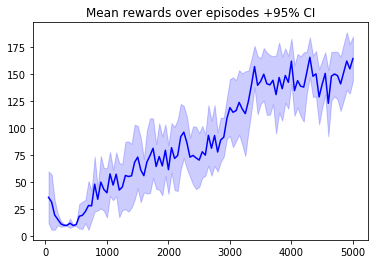

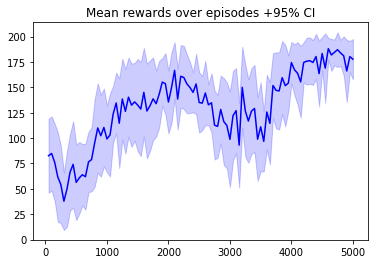

In [4]:
DQNrunner.plot(mode='ci')
DuelingDQNrunner.plot(mode='ci')
K.clear_session()

## Limited CartPole

Here I have implemented a modified task called limited CartPole (/tasks/limitedCartPole.py) which strips the velocity data from the standard gym environment before passing it to the Agents. As you can see below, neither is capable of even getting close to the high score. I also run them both for one super long run to show that this isn't just a matter of not training long enough.

In [5]:
limitedCP = limitedCartPole()

[2018-03-01 22:58:17,831] Making new env: CartPole-v0


In [6]:
DQNrunner = TestRunner(limitedCP, 'DQN', 5000, report_interval=50, print_test=True, runs=10)
DuelingDQNrunner = TestRunner(limitedCP, 'DuelingDQN', 5000, report_interval=50, print_test=True, runs=10)

DQNrunner.start()
print ("DQN FINISHED... STARTING DUELING DQN")
DuelingDQNrunner.start()

Starting Run: 0
Episode   50 - Testing  :     9.40
Episode  100 - Testing  :     9.60
Episode  150 - Testing  :     9.00
Episode  200 - Testing  :     9.60
Episode  250 - Testing  :     9.60
Episode  300 - Testing  :     9.60
Episode  350 - Testing  :     9.80
Episode  400 - Testing  :     9.80
Episode  450 - Testing  :    40.40
Episode  500 - Testing  :    46.40
Episode  550 - Testing  :    10.60
Episode  600 - Testing  :    12.20
Episode  650 - Testing  :    37.40
Episode  700 - Testing  :     9.80
Episode  750 - Testing  :    11.80
Episode  800 - Testing  :     9.20
Episode  850 - Testing  :    11.60
Episode  900 - Testing  :    11.40
Episode  950 - Testing  :    10.20
Episode 1000 - Testing  :    11.80
Episode 1050 - Testing  :     9.40
Episode 1100 - Testing  :     9.40
Episode 1150 - Testing  :    11.60
Episode 1200 - Testing  :    18.60
Episode 1250 - Testing  :     9.40
Episode 1300 - Testing  :     9.60
Episode 1350 - Testing  :    11.60
Episode 1400 - Testing  :     9.40
Epis

Episode 1500 - Testing  :    35.80
Episode 1550 - Testing  :    11.60
Episode 1600 - Testing  :    21.40
Episode 1650 - Testing  :    11.80
Episode 1700 - Testing  :    23.20
Episode 1750 - Testing  :    13.80
Episode 1800 - Testing  :    30.40
Episode 1850 - Testing  :    28.40
Episode 1900 - Testing  :    37.20
Episode 1950 - Testing  :    13.00
Episode 2000 - Testing  :    28.80
Episode 2050 - Testing  :    30.20
Episode 2100 - Testing  :    11.60
Episode 2150 - Testing  :    12.20
Episode 2200 - Testing  :    12.60
Episode 2250 - Testing  :    12.60
Episode 2300 - Testing  :    12.00
Episode 2350 - Testing  :    11.60
Episode 2400 - Testing  :    11.60
Episode 2450 - Testing  :    11.80
Episode 2500 - Testing  :    11.40
Episode 2550 - Testing  :    11.00
Episode 2600 - Testing  :    12.00
Episode 2650 - Testing  :    11.60
Episode 2700 - Testing  :    12.20
Episode 2750 - Testing  :    12.20
Episode 2800 - Testing  :    10.80
Episode 2850 - Testing  :    12.00
Episode 2900 - Testi

Episode 3050 - Testing  :    11.60
Episode 3100 - Testing  :    12.80
Episode 3150 - Testing  :    11.80
Episode 3200 - Testing  :    12.40
Episode 3250 - Testing  :    12.00
Episode 3300 - Testing  :    12.60
Episode 3350 - Testing  :    13.80
Episode 3400 - Testing  :    12.20
Episode 3450 - Testing  :    16.80
Episode 3500 - Testing  :    17.00
Episode 3550 - Testing  :    26.60
Episode 3600 - Testing  :    12.40
Episode 3650 - Testing  :    22.60
Episode 3700 - Testing  :    27.40
Episode 3750 - Testing  :    26.60
Episode 3800 - Testing  :    12.60
Episode 3850 - Testing  :    20.00
Episode 3900 - Testing  :    24.00
Episode 3950 - Testing  :    30.60
Episode 4000 - Testing  :    34.80
Episode 4050 - Testing  :    26.20
Episode 4100 - Testing  :    36.60
Episode 4150 - Testing  :    21.80
Episode 4200 - Testing  :    44.40
Episode 4250 - Testing  :    45.20
Episode 4300 - Testing  :    52.80
Episode 4350 - Testing  :    11.60
Episode 4400 - Testing  :    12.20
Episode 4450 - Testi

Episode 4600 - Testing  :    18.80
Episode 4650 - Testing  :    24.20
Episode 4700 - Testing  :    33.40
Episode 4750 - Testing  :    25.00
Episode 4800 - Testing  :    27.60
Episode 4850 - Testing  :    18.60
Episode 4900 - Testing  :    32.80
Episode 4950 - Testing  :    32.60
Episode 5000 - Testing  :    22.60
Starting Run: 7
Episode   50 - Testing  :    44.80
Episode  100 - Testing  :    47.40
Episode  150 - Testing  :    38.00
Episode  200 - Testing  :    31.00
Episode  250 - Testing  :    39.20
Episode  300 - Testing  :    11.40
Episode  350 - Testing  :    12.20
Episode  400 - Testing  :    12.40
Episode  450 - Testing  :     9.80
Episode  500 - Testing  :    44.40
Episode  550 - Testing  :     9.40
Episode  600 - Testing  :     9.20
Episode  650 - Testing  :    13.00
Episode  700 - Testing  :     9.40
Episode  750 - Testing  :    11.80
Episode  800 - Testing  :    11.00
Episode  850 - Testing  :    33.00
Episode  900 - Testing  :    11.60
Episode  950 - Testing  :    11.80
Epis

Episode 1050 - Testing  :     9.40
Episode 1100 - Testing  :     9.40
Episode 1150 - Testing  :     9.00
Episode 1200 - Testing  :     9.20
Episode 1250 - Testing  :    12.40
Episode 1300 - Testing  :    11.40
Episode 1350 - Testing  :    12.40
Episode 1400 - Testing  :    12.40
Episode 1450 - Testing  :    11.40
Episode 1500 - Testing  :     9.80
Episode 1550 - Testing  :    11.60
Episode 1600 - Testing  :    11.20
Episode 1650 - Testing  :     9.00
Episode 1700 - Testing  :    11.80
Episode 1750 - Testing  :    10.80
Episode 1800 - Testing  :    11.80
Episode 1850 - Testing  :    11.00
Episode 1900 - Testing  :    11.80
Episode 1950 - Testing  :     9.40
Episode 2000 - Testing  :    30.00
Episode 2050 - Testing  :    11.60
Episode 2100 - Testing  :    10.40
Episode 2150 - Testing  :    11.80
Episode 2200 - Testing  :    11.60
Episode 2250 - Testing  :    10.80
Episode 2300 - Testing  :    11.60
Episode 2350 - Testing  :    10.80
Episode 2400 - Testing  :    11.40
Episode 2450 - Testi

Episode 2550 - Testing  :    32.80
Episode 2600 - Testing  :    31.40
Episode 2650 - Testing  :    35.00
Episode 2700 - Testing  :    37.40
Episode 2750 - Testing  :    30.40
Episode 2800 - Testing  :    42.20
Episode 2850 - Testing  :    30.00
Episode 2900 - Testing  :    28.40
Episode 2950 - Testing  :    27.40
Episode 3000 - Testing  :    43.20
Episode 3050 - Testing  :    38.60
Episode 3100 - Testing  :    33.00
Episode 3150 - Testing  :    40.40
Episode 3200 - Testing  :    33.60
Episode 3250 - Testing  :    49.80
Episode 3300 - Testing  :    16.40
Episode 3350 - Testing  :    18.20
Episode 3400 - Testing  :    31.80
Episode 3450 - Testing  :    31.40
Episode 3500 - Testing  :    36.00
Episode 3550 - Testing  :    27.80
Episode 3600 - Testing  :    34.00
Episode 3650 - Testing  :    24.80
Episode 3700 - Testing  :    26.40
Episode 3750 - Testing  :    24.20
Episode 3800 - Testing  :    29.00
Episode 3850 - Testing  :    43.40
Episode 3900 - Testing  :    31.00
Episode 3950 - Testi

Episode 4100 - Testing  :    38.60
Episode 4150 - Testing  :    38.60
Episode 4200 - Testing  :    38.60
Episode 4250 - Testing  :    30.20
Episode 4300 - Testing  :    38.40
Episode 4350 - Testing  :    40.60
Episode 4400 - Testing  :    27.20
Episode 4450 - Testing  :    35.60
Episode 4500 - Testing  :    10.60
Episode 4550 - Testing  :    42.60
Episode 4600 - Testing  :    45.20
Episode 4650 - Testing  :    39.00
Episode 4700 - Testing  :    38.00
Episode 4750 - Testing  :    42.60
Episode 4800 - Testing  :    25.40
Episode 4850 - Testing  :    35.00
Episode 4900 - Testing  :    38.20
Episode 4950 - Testing  :    43.60
Episode 5000 - Testing  :    40.80
Starting Run: 4
Episode   50 - Testing  :    41.60
Episode  100 - Testing  :     8.80
Episode  150 - Testing  :    10.40
Episode  200 - Testing  :     9.20
Episode  250 - Testing  :     9.60
Episode  300 - Testing  :     9.20
Episode  350 - Testing  :     9.40
Episode  400 - Testing  :     9.80
Episode  450 - Testing  :    16.60
Epis

Episode  550 - Testing  :     9.40
Episode  600 - Testing  :     9.80
Episode  650 - Testing  :    11.80
Episode  700 - Testing  :    10.00
Episode  750 - Testing  :    17.40
Episode  800 - Testing  :    31.20
Episode  850 - Testing  :    38.20
Episode  900 - Testing  :    11.80
Episode  950 - Testing  :    31.40
Episode 1000 - Testing  :    11.60
Episode 1050 - Testing  :    32.20
Episode 1100 - Testing  :    11.80
Episode 1150 - Testing  :    12.60
Episode 1200 - Testing  :    11.60
Episode 1250 - Testing  :    27.80
Episode 1300 - Testing  :    23.40
Episode 1350 - Testing  :    31.80
Episode 1400 - Testing  :    38.80
Episode 1450 - Testing  :    51.80
Episode 1500 - Testing  :    43.00
Episode 1550 - Testing  :    50.00
Episode 1600 - Testing  :     9.60
Episode 1650 - Testing  :    47.40
Episode 1700 - Testing  :    29.80
Episode 1750 - Testing  :    35.80
Episode 1800 - Testing  :    12.20
Episode 1850 - Testing  :    11.40
Episode 1900 - Testing  :    40.00
Episode 1950 - Testi

Episode 2100 - Testing  :    10.60
Episode 2150 - Testing  :    11.80
Episode 2200 - Testing  :    19.60
Episode 2250 - Testing  :     9.20
Episode 2300 - Testing  :     9.00
Episode 2350 - Testing  :     8.80
Episode 2400 - Testing  :    34.80
Episode 2450 - Testing  :     9.20
Episode 2500 - Testing  :    34.00
Episode 2550 - Testing  :    28.80
Episode 2600 - Testing  :    17.00
Episode 2650 - Testing  :     9.80
Episode 2700 - Testing  :     9.40
Episode 2750 - Testing  :    11.20
Episode 2800 - Testing  :    11.40
Episode 2850 - Testing  :     9.80
Episode 2900 - Testing  :     9.20
Episode 2950 - Testing  :     9.00
Episode 3000 - Testing  :    11.20
Episode 3050 - Testing  :    10.00
Episode 3100 - Testing  :    10.00
Episode 3150 - Testing  :    12.20
Episode 3200 - Testing  :    10.60
Episode 3250 - Testing  :     9.60
Episode 3300 - Testing  :    11.00
Episode 3350 - Testing  :    12.00
Episode 3400 - Testing  :    11.80
Episode 3450 - Testing  :    19.20
Episode 3500 - Testi

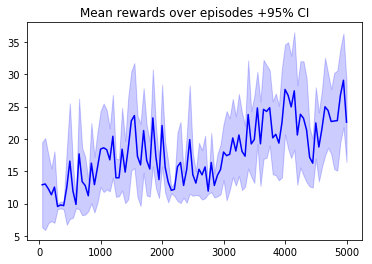

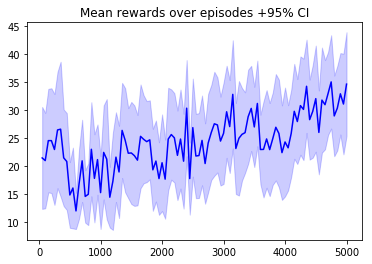

In [7]:
DQNrunner.plot(mode='ci')
DuelingDQNrunner.plot(mode='ci')
K.clear_session()

In [8]:
DQNrunner = TestRunner(limitedCP, 'DQN', 100000, report_interval=500, print_test=True, runs=1)
DuelingDQNrunner = TestRunner(limitedCP, 'DuelingDQN', 100000, report_interval=500, print_test=True, runs=1)

DQNrunner.start()
DuelingDQNrunner.start()

Starting Run: 0
Episode  500 - Testing  :     9.40
Episode 1000 - Testing  :    11.80
Episode 1500 - Testing  :    11.60
Episode 2000 - Testing  :    17.00
Episode 2500 - Testing  :    12.40
Episode 3000 - Testing  :    12.60
Episode 3500 - Testing  :    16.40
Episode 4000 - Testing  :    12.60
Episode 4500 - Testing  :    22.00
Episode 5000 - Testing  :    36.60
Episode 5500 - Testing  :    34.80
Episode 6000 - Testing  :    44.20
Episode 6500 - Testing  :     9.40
Episode 7000 - Testing  :    41.00
Episode 7500 - Testing  :    43.40
Episode 8000 - Testing  :    11.80
Episode 8500 - Testing  :    31.60
Episode 9000 - Testing  :    31.00
Episode 9500 - Testing  :    40.80
Episode 10000 - Testing  :    41.60
Episode 10500 - Testing  :    43.80
Episode 11000 - Testing  :    12.00
Episode 11500 - Testing  :    30.20
Episode 12000 - Testing  :    11.60
Episode 12500 - Testing  :    11.80
Episode 13000 - Testing  :    33.40
Episode 13500 - Testing  :    18.60
Episode 14000 - Testing  :    1

Episode 13000 - Testing  :    12.60
Episode 13500 - Testing  :    11.60
Episode 14000 - Testing  :    36.20
Episode 14500 - Testing  :    37.20
Episode 15000 - Testing  :    41.00
Episode 15500 - Testing  :    38.20
Episode 16000 - Testing  :    28.20
Episode 16500 - Testing  :    34.40
Episode 17000 - Testing  :    27.80
Episode 17500 - Testing  :    54.80
Episode 18000 - Testing  :    16.80
Episode 18500 - Testing  :    32.00
Episode 19000 - Testing  :    39.60
Episode 19500 - Testing  :    43.00
Episode 20000 - Testing  :    43.20
Episode 20500 - Testing  :    42.60
Episode 21000 - Testing  :    11.40
Episode 21500 - Testing  :    28.20
Episode 22000 - Testing  :    42.00
Episode 22500 - Testing  :    44.80
Episode 23000 - Testing  :    39.80
Episode 23500 - Testing  :    43.00
Episode 24000 - Testing  :    27.60
Episode 24500 - Testing  :    26.20
Episode 25000 - Testing  :    14.20
Episode 25500 - Testing  :    33.80
Episode 26000 - Testing  :    37.60
Episode 26500 - Testing  :  

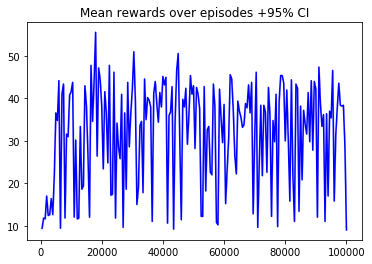

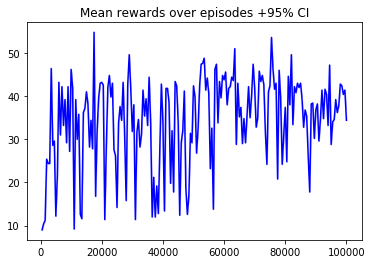

In [9]:
DQNrunner.plot(mode='ci')
DuelingDQNrunner.plot(mode='ci')
K.clear_session()

## Recurrent DQN

Now the meat of this, Below I have implemented a recurrent DQN network by swapping out the first Dense layer for a LSTM layer. In order to train this, batches of sequential timesteps must be fed to it. This led to several complications. Based on the literature, I opted for a replay memory which would record all experiences in one long buffer and then choose starting points at random and read the next seqlen experiences into a buffer. Here I am using a sequence length of 5. While this allows for the possibility of a training sequence which rolls over between two episodes, in practice HausKnecht and Stone said that this did not make a difference in their experience. All the same, I would like to test a method that doesn't allow this roll over to happen to see if it makes a difference here.


In [30]:
from keras import layers, models, optimizers
from keras.regularizers import *
from replay import DumbReplayBuffer as ReplayBuffer
from keras import backend as K

def AdvantageMerge(AV):
    A = AV[0]
    V = AV[1]
    return V+A/(K.mean(A, axis=-1, keepdims=True)+K.epsilon())

def process_state(state, mask):
    state = np.reshape(state, [1,1,-1])
    return state

class RDQN_Model():
    def __init__(self, batch_size, edim, adim, learning_rate):
        self.batch_size = batch_size
        self.edim = edim
        self.adim = adim
        
         # Input is environment vector
        inp = layers.Input(batch_shape=(batch_size, None, edim), name='Input')
        
        net = layers.LSTM(10, stateful=True, return_sequences=True)(inp)
        
        net = layers.Dense(10, activation='relu')(net)
        
        V_net = layers.Dense(5, activation='relu')(net)
        V_net = layers.Dense(1, activation=None)(V_net)
        
        A_net = layers.Dense(5, activation='relu')(net)
        A_net = layers.Dense(adim, activation=None)(A_net)
        
        Q_Values = layers.Lambda(AdvantageMerge)([A_net, V_net])
        
        
        self.model = models.Model(inputs=inp, outputs=Q_Values)
#         self.model.compile(loss='mse', optimizer=optimizers.Adam(lr=learning_rate, clipnorm=0.5))
        
        choice = layers.Input(batch_shape=(None, None), name='Choice', dtype='int32')
        target = layers.Input(batch_shape=(None, None), name='Target')
        
        # Manual Train function
        self.Qs = K.function(inputs=[inp], outputs=[Q_Values])
        
        mult = K.one_hot(choice, self.adim)*Q_Values
        self.mult = K.function(inputs=[inp, choice], outputs=[mult])
        
        chosen = K.sum(K.one_hot(choice, self.adim)*Q_Values, axis=2)
        self.chosen = K.function(inputs=[inp, choice], outputs=[chosen])
        
        td = target-K.sum(K.one_hot(choice, self.adim)*Q_Values, axis=2)
        self.td = K.function(inputs=[inp, choice, target], outputs=[td])
        
        loss = K.mean(K.square(target-K.sum(K.one_hot(choice, self.adim)*Q_Values, axis=2)))
        self.loss = K.function(inputs=[inp, choice, target], outputs=[loss])
        
        optimizer = optimizers.Adam(lr=learning_rate, clipnorm=0.5)
        updates = optimizer.get_updates(loss, self.model.trainable_weights)
        self.train = K.function(inputs=[inp, choice, target], outputs=[], updates=updates)
        

class RDQN(BaseAgent):
    def __init__(self, env):
        self.buffer_size = 20000
        self.batch_size = 64
        self.seq_len = 5
        self.tau = 0.6
        self.gamma = 0.95
        self.learning_rate = 0.001
        
        # Exploration Parameters
        self.E_start = 1
        self.E_end   = 0.2
        self.E_decay = 0.00005
        self.episode = 0
        
        self.env = env
        self.os = self.env.observation_space
        
        self.edim = len(self.os.high)
        self.adim = self.env.action_space.n
        
        self.buffer = ReplayBuffer(self.buffer_size, self.edim, 1)
        
        self.actor  = RDQN_Model(1, self.edim, self.adim, self.learning_rate)
        self.local  = RDQN_Model(self.batch_size, self.edim, self.adim, self.learning_rate)
        self.target = RDQN_Model(self.batch_size, self.edim, self.adim, self.learning_rate)
        
        
        self.initial_weights = self.local.model.get_weights()
        self.actor.model.set_weights(self.initial_weights)
        self.target.model.set_weights(self.initial_weights)
        
    def act(self, state, testing):
        state = np.reshape(state, [1,1,-1])
        
        actionQs = self.actor.model.predict(state)
        action = np.argmax(actionQs)
        
        epsilon = self.E_end + (self.E_start - self.E_end)*np.exp(-self.E_decay*self.episode)
        if (not testing):
            if (np.random.rand() < epsilon):
                action = np.random.choice(self.adim)
        
#         action = np.array([action])
        
        return action
    
    def learn(self, state, action, reward, next_state, done, testing):
        state = np.reshape(state, [1,1,-1])
        next_state = np.reshape(next_state, [1,1,-1])
        
        # Skip all learning during testing
        if (testing):
            return
        
        act_index = action
        
        self.buffer.add(state, act_index, reward, next_state, done)
        
        if (done):
            self.reset_states()
            self.episode += 1
        
        # TODO When upgrading to RDPG this should be per-episode based  

            states, actions, rewards, next_states, dones = self.buffer.batch(self.batch_size, self.seq_len)
            # Not enough samples yet
            if (states is None):
                return

            actions.astype(int)
            actions = np.squeeze(actions, axis=-1)
            
            # Bellman equation
            target_Q = rewards + self.gamma*np.amax(self.target.model.predict_on_batch(next_states), axis=2)*(1-dones)
            
            self.local.train([states, actions, target_Q])
            
            self.reset_states()
            
            self.soft_update(self.actor, self.local, 1)
            self.soft_update(self.target, self.local, self.tau)
        
    def reset_states(self):
        self.actor.model.reset_states()
        self.local.model.reset_states()
        self.target.model.reset_states()     
        
    def soft_update(self, target, local, tau):
        local_weights = np.array(local.model.get_weights())
        target_weights = np.array(target.model.get_weights())
        
        new_target_weights = (1-tau)*target_weights + tau*local_weights
        
        target.model.set_weights(new_target_weights)
        
    def reset(self):
        shuffle_weights(self.local.model, self.initial_weights)
        self.actor.model.set_weights(self.local.model.get_weights())
        self.target.model.set_weights(self.local.model.get_weights())
        self.episode = 0
    

In [31]:
agent = RDQN(limitedCP)
runner = TestRunner(limitedCP, agent, 50000, report_interval=100, print_test=True, runs=10)
runner.start()

Starting Run: 0
Episode  100 - Testing  :    10.40
Episode  200 - Testing  :    11.40
Episode  300 - Testing  :     9.40
Episode  400 - Testing  :    11.20
Episode  500 - Testing  :     9.00
Episode  600 - Testing  :     9.40
Episode  700 - Testing  :    10.00
Episode  800 - Testing  :     9.80
Episode  900 - Testing  :    11.20
Episode 1000 - Testing  :     9.20
Episode 1100 - Testing  :    11.60
Episode 1200 - Testing  :    22.40
Episode 1300 - Testing  :    19.80
Episode 1400 - Testing  :    22.20
Episode 1500 - Testing  :    15.40
Episode 1600 - Testing  :    19.20
Episode 1700 - Testing  :    18.20
Episode 1800 - Testing  :    18.00
Episode 1900 - Testing  :    17.80
Episode 2000 - Testing  :    15.80
Episode 2100 - Testing  :    16.20
Episode 2200 - Testing  :    15.40
Episode 2300 - Testing  :    15.60
Episode 2400 - Testing  :    11.40
Episode 2500 - Testing  :    13.40
Episode 2600 - Testing  :    16.00
Episode 2700 - Testing  :    14.20
Episode 2800 - Testing  :    14.40
Epis

Episode 23000 - Testing  :   200.00
Episode 23100 - Testing  :   127.80
Episode 23200 - Testing  :   162.20
Episode 23300 - Testing  :   170.20
Episode 23400 - Testing  :   182.40
Episode 23500 - Testing  :    14.40
Episode 23600 - Testing  :   158.00
Episode 23700 - Testing  :    17.60
Episode 23800 - Testing  :   113.00
Episode 23900 - Testing  :   104.80
Episode 24000 - Testing  :   200.00
Episode 24100 - Testing  :   200.00
Episode 24200 - Testing  :    13.80
Episode 24300 - Testing  :   115.80
Episode 24400 - Testing  :   107.60
Episode 24500 - Testing  :   116.60
Episode 24600 - Testing  :   199.40
Episode 24700 - Testing  :   135.20
Episode 24800 - Testing  :   197.80
Episode 24900 - Testing  :    72.40
Episode 25000 - Testing  :    11.60
Episode 25100 - Testing  :    13.20
Episode 25200 - Testing  :    18.00
Episode 25300 - Testing  :   168.80
Episode 25400 - Testing  :   192.20
Episode 25500 - Testing  :   200.00
Episode 25600 - Testing  :   200.00
Episode 25700 - Testing  :  

Episode 45800 - Testing  :   191.20
Episode 45900 - Testing  :   159.20
Episode 46000 - Testing  :   191.20
Episode 46100 - Testing  :   166.40
Episode 46200 - Testing  :   118.60
Episode 46300 - Testing  :   111.80
Episode 46400 - Testing  :    13.40
Episode 46500 - Testing  :   200.00
Episode 46600 - Testing  :   190.20
Episode 46700 - Testing  :   122.80
Episode 46800 - Testing  :   200.00
Episode 46900 - Testing  :   194.00
Episode 47000 - Testing  :    99.60
Episode 47100 - Testing  :   171.60
Episode 47200 - Testing  :   200.00
Episode 47300 - Testing  :   151.40
Episode 47400 - Testing  :   114.00
Episode 47500 - Testing  :   140.60
Episode 47600 - Testing  :   200.00
Episode 47700 - Testing  :   165.40
Episode 47800 - Testing  :    21.20
Episode 47900 - Testing  :   151.20
Episode 48000 - Testing  :    97.60
Episode 48100 - Testing  :    12.40
Episode 48200 - Testing  :   181.20
Episode 48300 - Testing  :   167.60
Episode 48400 - Testing  :   107.80
Episode 48500 - Testing  :  

Episode 18700 - Testing  :    12.20
Episode 18800 - Testing  :     9.80
Episode 18900 - Testing  :    10.00
Episode 19000 - Testing  :     9.20
Episode 19100 - Testing  :     9.60
Episode 19200 - Testing  :    12.80
Episode 19300 - Testing  :    12.20
Episode 19400 - Testing  :    12.60
Episode 19500 - Testing  :    10.80
Episode 19600 - Testing  :    13.40
Episode 19700 - Testing  :     9.40
Episode 19800 - Testing  :    13.80
Episode 19900 - Testing  :     9.60
Episode 20000 - Testing  :    11.00
Episode 20100 - Testing  :    10.80
Episode 20200 - Testing  :     9.80
Episode 20300 - Testing  :     9.60
Episode 20400 - Testing  :     9.40
Episode 20500 - Testing  :     9.40
Episode 20600 - Testing  :     9.00
Episode 20700 - Testing  :    12.00
Episode 20800 - Testing  :    12.60
Episode 20900 - Testing  :    13.40
Episode 21000 - Testing  :    11.80
Episode 21100 - Testing  :    13.20
Episode 21200 - Testing  :    10.60
Episode 21300 - Testing  :    13.00
Episode 21400 - Testing  :  

Episode 41500 - Testing  :   120.40
Episode 41600 - Testing  :    68.80
Episode 41700 - Testing  :   145.40
Episode 41800 - Testing  :   113.40
Episode 41900 - Testing  :   200.00
Episode 42000 - Testing  :    12.20
Episode 42100 - Testing  :   200.00
Episode 42200 - Testing  :    11.40
Episode 42300 - Testing  :   191.00
Episode 42400 - Testing  :    13.20
Episode 42500 - Testing  :   190.40
Episode 42600 - Testing  :     9.40
Episode 42700 - Testing  :   186.60
Episode 42800 - Testing  :    10.20
Episode 42900 - Testing  :   125.20
Episode 43000 - Testing  :   123.00
Episode 43100 - Testing  :   198.00
Episode 43200 - Testing  :    72.00
Episode 43300 - Testing  :    13.00
Episode 43400 - Testing  :   200.00
Episode 43500 - Testing  :    34.00
Episode 43600 - Testing  :    11.40
Episode 43700 - Testing  :   135.40
Episode 43800 - Testing  :   101.80
Episode 43900 - Testing  :   168.00
Episode 44000 - Testing  :   139.80
Episode 44100 - Testing  :    64.20
Episode 44200 - Testing  :  

Episode 14400 - Testing  :    45.60
Episode 14500 - Testing  :    13.60
Episode 14600 - Testing  :    57.80
Episode 14700 - Testing  :    42.40
Episode 14800 - Testing  :    24.00
Episode 14900 - Testing  :    33.20
Episode 15000 - Testing  :    18.80
Episode 15100 - Testing  :    27.60
Episode 15200 - Testing  :    14.00
Episode 15300 - Testing  :    78.00
Episode 15400 - Testing  :    42.80
Episode 15500 - Testing  :    19.20
Episode 15600 - Testing  :   145.40
Episode 15700 - Testing  :    39.40
Episode 15800 - Testing  :    38.40
Episode 15900 - Testing  :    14.60
Episode 16000 - Testing  :    13.20
Episode 16100 - Testing  :    46.80
Episode 16200 - Testing  :    19.40
Episode 16300 - Testing  :    14.00
Episode 16400 - Testing  :    15.40
Episode 16500 - Testing  :    21.60
Episode 16600 - Testing  :    13.60
Episode 16700 - Testing  :    78.60
Episode 16800 - Testing  :    13.60
Episode 16900 - Testing  :   178.60
Episode 17000 - Testing  :    97.80
Episode 17100 - Testing  :  

Episode 37200 - Testing  :   152.60
Episode 37300 - Testing  :   130.80
Episode 37400 - Testing  :   167.40
Episode 37500 - Testing  :   101.60
Episode 37600 - Testing  :   120.80
Episode 37700 - Testing  :    34.40
Episode 37800 - Testing  :    23.80
Episode 37900 - Testing  :    16.00
Episode 38000 - Testing  :    12.40
Episode 38100 - Testing  :    44.00
Episode 38200 - Testing  :    14.00
Episode 38300 - Testing  :    67.00
Episode 38400 - Testing  :    13.20
Episode 38500 - Testing  :   124.00
Episode 38600 - Testing  :   125.60
Episode 38700 - Testing  :   170.40
Episode 38800 - Testing  :   128.40
Episode 38900 - Testing  :   142.80
Episode 39000 - Testing  :   102.80
Episode 39100 - Testing  :   200.00
Episode 39200 - Testing  :    63.60
Episode 39300 - Testing  :    10.40
Episode 39400 - Testing  :    82.60
Episode 39500 - Testing  :   200.00
Episode 39600 - Testing  :   192.40
Episode 39700 - Testing  :   200.00
Episode 39800 - Testing  :    14.00
Episode 39900 - Testing  :  

Episode 10100 - Testing  :    12.60
Episode 10200 - Testing  :    11.00
Episode 10300 - Testing  :    10.60
Episode 10400 - Testing  :    11.60
Episode 10500 - Testing  :    11.00
Episode 10600 - Testing  :    11.60
Episode 10700 - Testing  :    11.60
Episode 10800 - Testing  :    11.40
Episode 10900 - Testing  :    13.80
Episode 11000 - Testing  :    10.40
Episode 11100 - Testing  :    10.60
Episode 11200 - Testing  :    11.00
Episode 11300 - Testing  :    12.60
Episode 11400 - Testing  :    12.60
Episode 11500 - Testing  :    10.40
Episode 11600 - Testing  :    16.20
Episode 11700 - Testing  :    11.80
Episode 11800 - Testing  :    10.80
Episode 11900 - Testing  :     9.60
Episode 12000 - Testing  :    15.40
Episode 12100 - Testing  :     9.40
Episode 12200 - Testing  :    10.60
Episode 12300 - Testing  :    10.60
Episode 12400 - Testing  :    11.80
Episode 12500 - Testing  :    11.20
Episode 12600 - Testing  :    16.20
Episode 12700 - Testing  :    10.20
Episode 12800 - Testing  :  

Episode 32900 - Testing  :     9.40
Episode 33000 - Testing  :     9.40
Episode 33100 - Testing  :    10.00
Episode 33200 - Testing  :     9.60
Episode 33300 - Testing  :     8.80
Episode 33400 - Testing  :     9.20
Episode 33500 - Testing  :     9.80
Episode 33600 - Testing  :     9.00
Episode 33700 - Testing  :     9.60
Episode 33800 - Testing  :    11.20
Episode 33900 - Testing  :     9.60
Episode 34000 - Testing  :    10.40
Episode 34100 - Testing  :    11.60
Episode 34200 - Testing  :    11.40
Episode 34300 - Testing  :     9.00
Episode 34400 - Testing  :    11.20
Episode 34500 - Testing  :    10.00
Episode 34600 - Testing  :    11.20
Episode 34700 - Testing  :    11.20
Episode 34800 - Testing  :    11.00
Episode 34900 - Testing  :    11.40
Episode 35000 - Testing  :    10.20
Episode 35100 - Testing  :     9.20
Episode 35200 - Testing  :     9.60
Episode 35300 - Testing  :    12.40
Episode 35400 - Testing  :     9.20
Episode 35500 - Testing  :    10.00
Episode 35600 - Testing  :  

Episode 5700 - Testing  :    25.80
Episode 5800 - Testing  :    16.00
Episode 5900 - Testing  :    11.40
Episode 6000 - Testing  :    12.00
Episode 6100 - Testing  :    17.60
Episode 6200 - Testing  :    16.80
Episode 6300 - Testing  :    11.80
Episode 6400 - Testing  :    13.60
Episode 6500 - Testing  :     8.80
Episode 6600 - Testing  :    37.00
Episode 6700 - Testing  :     9.80
Episode 6800 - Testing  :    15.00
Episode 6900 - Testing  :    70.00
Episode 7000 - Testing  :    20.40
Episode 7100 - Testing  :    21.00
Episode 7200 - Testing  :    26.80
Episode 7300 - Testing  :    13.40
Episode 7400 - Testing  :    11.60
Episode 7500 - Testing  :    86.80
Episode 7600 - Testing  :    51.20
Episode 7700 - Testing  :    10.40
Episode 7800 - Testing  :    31.00
Episode 7900 - Testing  :    64.20
Episode 8000 - Testing  :     9.80
Episode 8100 - Testing  :     9.60
Episode 8200 - Testing  :   143.00
Episode 8300 - Testing  :     9.40
Episode 8400 - Testing  :    13.20
Episode 8500 - Testi

Episode 28600 - Testing  :    15.20
Episode 28700 - Testing  :    85.20
Episode 28800 - Testing  :   156.20
Episode 28900 - Testing  :    79.40
Episode 29000 - Testing  :    12.20
Episode 29100 - Testing  :   116.00
Episode 29200 - Testing  :    11.40
Episode 29300 - Testing  :    60.00
Episode 29400 - Testing  :    54.40
Episode 29500 - Testing  :   114.80
Episode 29600 - Testing  :   130.80
Episode 29700 - Testing  :    55.40
Episode 29800 - Testing  :    37.60
Episode 29900 - Testing  :    68.60
Episode 30000 - Testing  :    43.20
Episode 30100 - Testing  :    32.80
Episode 30200 - Testing  :    21.00
Episode 30300 - Testing  :   116.80
Episode 30400 - Testing  :   102.40
Episode 30500 - Testing  :    69.20
Episode 30600 - Testing  :    49.40
Episode 30700 - Testing  :    40.80
Episode 30800 - Testing  :    49.60
Episode 30900 - Testing  :    20.40
Episode 31000 - Testing  :    17.80
Episode 31100 - Testing  :    57.60
Episode 31200 - Testing  :    25.80
Episode 31300 - Testing  :  

Episode 1200 - Testing  :    16.40
Episode 1300 - Testing  :     9.60
Episode 1400 - Testing  :     9.00
Episode 1500 - Testing  :    12.40
Episode 1600 - Testing  :    10.60
Episode 1700 - Testing  :     9.80
Episode 1800 - Testing  :    10.80
Episode 1900 - Testing  :    14.60
Episode 2000 - Testing  :     9.60
Episode 2100 - Testing  :    11.20
Episode 2200 - Testing  :    14.60
Episode 2300 - Testing  :    32.80
Episode 2400 - Testing  :    13.80
Episode 2500 - Testing  :    12.80
Episode 2600 - Testing  :    12.20
Episode 2700 - Testing  :    12.40
Episode 2800 - Testing  :    11.40
Episode 2900 - Testing  :    12.20
Episode 3000 - Testing  :    10.60
Episode 3100 - Testing  :    11.20
Episode 3200 - Testing  :    24.20
Episode 3300 - Testing  :    16.60
Episode 3400 - Testing  :    11.00
Episode 3500 - Testing  :    33.20
Episode 3600 - Testing  :    15.00
Episode 3700 - Testing  :    11.40
Episode 3800 - Testing  :    10.00
Episode 3900 - Testing  :    37.20
Episode 4000 - Testi

Episode 24300 - Testing  :   128.00
Episode 24400 - Testing  :   183.40
Episode 24500 - Testing  :   143.40
Episode 24600 - Testing  :    23.00
Episode 24700 - Testing  :   127.00
Episode 24800 - Testing  :   153.20
Episode 24900 - Testing  :   185.60
Episode 25000 - Testing  :    34.80
Episode 25100 - Testing  :   138.60
Episode 25200 - Testing  :   140.00
Episode 25300 - Testing  :   153.80
Episode 25400 - Testing  :    71.60
Episode 25500 - Testing  :    25.20
Episode 25600 - Testing  :    79.40
Episode 25700 - Testing  :   173.60
Episode 25800 - Testing  :    10.40
Episode 25900 - Testing  :   200.00
Episode 26000 - Testing  :   110.20
Episode 26100 - Testing  :   111.00
Episode 26200 - Testing  :   145.60
Episode 26300 - Testing  :   177.40
Episode 26400 - Testing  :    79.80
Episode 26500 - Testing  :    18.20
Episode 26600 - Testing  :   143.00
Episode 26700 - Testing  :    66.20
Episode 26800 - Testing  :    85.00
Episode 26900 - Testing  :    23.40
Episode 27000 - Testing  :  

Episode 47100 - Testing  :   110.00
Episode 47200 - Testing  :   112.00
Episode 47300 - Testing  :    32.00
Episode 47400 - Testing  :    41.20
Episode 47500 - Testing  :    74.20
Episode 47600 - Testing  :    30.40
Episode 47700 - Testing  :    95.80
Episode 47800 - Testing  :    77.00
Episode 47900 - Testing  :    49.00
Episode 48000 - Testing  :    37.60
Episode 48100 - Testing  :    76.00
Episode 48200 - Testing  :    10.00
Episode 48300 - Testing  :   170.40
Episode 48400 - Testing  :   111.40
Episode 48500 - Testing  :    88.20
Episode 48600 - Testing  :    10.60
Episode 48700 - Testing  :    91.20
Episode 48800 - Testing  :    36.40
Episode 48900 - Testing  :    42.40
Episode 49000 - Testing  :    73.20
Episode 49100 - Testing  :    18.60
Episode 49200 - Testing  :    27.40
Episode 49300 - Testing  :   136.80
Episode 49400 - Testing  :    87.80
Episode 49500 - Testing  :    76.00
Episode 49600 - Testing  :    85.20
Episode 49700 - Testing  :   132.80
Episode 49800 - Testing  :  

Episode 20000 - Testing  :    13.80
Episode 20100 - Testing  :    10.60
Episode 20200 - Testing  :     9.60
Episode 20300 - Testing  :     9.20
Episode 20400 - Testing  :    12.40
Episode 20500 - Testing  :    11.80
Episode 20600 - Testing  :     9.40
Episode 20700 - Testing  :    14.80
Episode 20800 - Testing  :    44.20
Episode 20900 - Testing  :    17.80
Episode 21000 - Testing  :    17.80
Episode 21100 - Testing  :    15.40
Episode 21200 - Testing  :    12.00
Episode 21300 - Testing  :    28.00
Episode 21400 - Testing  :    27.40
Episode 21500 - Testing  :    17.80
Episode 21600 - Testing  :    15.40
Episode 21700 - Testing  :    14.80
Episode 21800 - Testing  :     9.80
Episode 21900 - Testing  :    15.40
Episode 22000 - Testing  :    36.00
Episode 22100 - Testing  :    13.40
Episode 22200 - Testing  :    15.60
Episode 22300 - Testing  :    14.60
Episode 22400 - Testing  :    12.00
Episode 22500 - Testing  :    13.20
Episode 22600 - Testing  :    11.00
Episode 22700 - Testing  :  

Episode 42800 - Testing  :    38.20
Episode 42900 - Testing  :    29.00
Episode 43000 - Testing  :    87.80
Episode 43100 - Testing  :    79.80
Episode 43200 - Testing  :    53.80
Episode 43300 - Testing  :    47.60
Episode 43400 - Testing  :    41.40
Episode 43500 - Testing  :    32.00
Episode 43600 - Testing  :    16.80
Episode 43700 - Testing  :    57.20
Episode 43800 - Testing  :    32.60
Episode 43900 - Testing  :    32.20
Episode 44000 - Testing  :    43.60
Episode 44100 - Testing  :    62.40
Episode 44200 - Testing  :    30.40
Episode 44300 - Testing  :    29.20
Episode 44400 - Testing  :    96.20
Episode 44500 - Testing  :    24.00
Episode 44600 - Testing  :    18.40
Episode 44700 - Testing  :    24.60
Episode 44800 - Testing  :   101.40
Episode 44900 - Testing  :    19.00
Episode 45000 - Testing  :    48.80
Episode 45100 - Testing  :    41.60
Episode 45200 - Testing  :    49.20
Episode 45300 - Testing  :   101.00
Episode 45400 - Testing  :    14.60
Episode 45500 - Testing  :  

Episode 15700 - Testing  :    12.80
Episode 15800 - Testing  :    56.80
Episode 15900 - Testing  :    56.80
Episode 16000 - Testing  :    19.20
Episode 16100 - Testing  :   200.00
Episode 16200 - Testing  :   108.20
Episode 16300 - Testing  :   142.80
Episode 16400 - Testing  :   187.20
Episode 16500 - Testing  :   118.60
Episode 16600 - Testing  :   119.80
Episode 16700 - Testing  :    18.40
Episode 16800 - Testing  :   194.60
Episode 16900 - Testing  :    11.20
Episode 17000 - Testing  :    62.80
Episode 17100 - Testing  :   178.80
Episode 17200 - Testing  :   111.60
Episode 17300 - Testing  :   200.00
Episode 17400 - Testing  :    54.60
Episode 17500 - Testing  :   121.20
Episode 17600 - Testing  :    31.80
Episode 17700 - Testing  :   186.40
Episode 17800 - Testing  :   137.20
Episode 17900 - Testing  :   160.40
Episode 18000 - Testing  :   147.60
Episode 18100 - Testing  :    10.80
Episode 18200 - Testing  :   151.60
Episode 18300 - Testing  :    25.80
Episode 18400 - Testing  :  

Episode 38500 - Testing  :    49.20
Episode 38600 - Testing  :    19.60
Episode 38700 - Testing  :   151.80
Episode 38800 - Testing  :   141.60
Episode 38900 - Testing  :   166.00
Episode 39000 - Testing  :    31.80
Episode 39100 - Testing  :   180.00
Episode 39200 - Testing  :    35.00
Episode 39300 - Testing  :    22.00
Episode 39400 - Testing  :   187.20
Episode 39500 - Testing  :   200.00
Episode 39600 - Testing  :   193.20
Episode 39700 - Testing  :    31.40
Episode 39800 - Testing  :   184.20
Episode 39900 - Testing  :   118.20
Episode 40000 - Testing  :    31.80
Episode 40100 - Testing  :   200.00
Episode 40200 - Testing  :    35.20
Episode 40300 - Testing  :   200.00
Episode 40400 - Testing  :   200.00
Episode 40500 - Testing  :   116.80
Episode 40600 - Testing  :    21.20
Episode 40700 - Testing  :    37.00
Episode 40800 - Testing  :   114.80
Episode 40900 - Testing  :   188.80
Episode 41000 - Testing  :    36.20
Episode 41100 - Testing  :    52.80
Episode 41200 - Testing  :  

Episode 11400 - Testing  :    38.20
Episode 11500 - Testing  :    17.60
Episode 11600 - Testing  :    29.80
Episode 11700 - Testing  :    13.40
Episode 11800 - Testing  :     9.80
Episode 11900 - Testing  :    12.80
Episode 12000 - Testing  :    12.20
Episode 12100 - Testing  :    22.60
Episode 12200 - Testing  :     9.60
Episode 12300 - Testing  :    30.40
Episode 12400 - Testing  :    30.20
Episode 12500 - Testing  :    19.40
Episode 12600 - Testing  :    28.40
Episode 12700 - Testing  :    18.40
Episode 12800 - Testing  :    36.40
Episode 12900 - Testing  :    28.60
Episode 13000 - Testing  :     9.60
Episode 13100 - Testing  :    31.00
Episode 13200 - Testing  :    23.80
Episode 13300 - Testing  :    24.60
Episode 13400 - Testing  :    14.20
Episode 13500 - Testing  :    14.00
Episode 13600 - Testing  :    15.60
Episode 13700 - Testing  :    31.40
Episode 13800 - Testing  :    22.40
Episode 13900 - Testing  :    32.40
Episode 14000 - Testing  :    23.60
Episode 14100 - Testing  :  

Episode 34200 - Testing  :    14.20
Episode 34300 - Testing  :    27.60
Episode 34400 - Testing  :    17.60
Episode 34500 - Testing  :    28.00
Episode 34600 - Testing  :    33.60
Episode 34700 - Testing  :    35.20
Episode 34800 - Testing  :    30.40
Episode 34900 - Testing  :    29.80
Episode 35000 - Testing  :    11.20
Episode 35100 - Testing  :    11.60
Episode 35200 - Testing  :    23.80
Episode 35300 - Testing  :    29.40
Episode 35400 - Testing  :    31.00
Episode 35500 - Testing  :    33.80
Episode 35600 - Testing  :    26.60
Episode 35700 - Testing  :    19.80
Episode 35800 - Testing  :    14.20
Episode 35900 - Testing  :    21.00
Episode 36000 - Testing  :    21.80
Episode 36100 - Testing  :    13.80
Episode 36200 - Testing  :    12.60
Episode 36300 - Testing  :    25.80
Episode 36400 - Testing  :    28.20
Episode 36500 - Testing  :    33.20
Episode 36600 - Testing  :    21.80
Episode 36700 - Testing  :    15.20
Episode 36800 - Testing  :    40.00
Episode 36900 - Testing  :  

Episode 7000 - Testing  :    92.00
Episode 7100 - Testing  :     9.20
Episode 7200 - Testing  :     9.40
Episode 7300 - Testing  :     8.80
Episode 7400 - Testing  :     9.20
Episode 7500 - Testing  :    12.00
Episode 7600 - Testing  :    10.40
Episode 7700 - Testing  :    27.60
Episode 7800 - Testing  :    16.60
Episode 7900 - Testing  :   200.00
Episode 8000 - Testing  :    12.20
Episode 8100 - Testing  :    63.20
Episode 8200 - Testing  :    81.00
Episode 8300 - Testing  :   200.00
Episode 8400 - Testing  :   103.40
Episode 8500 - Testing  :   200.00
Episode 8600 - Testing  :    66.80
Episode 8700 - Testing  :    13.00
Episode 8800 - Testing  :    14.80
Episode 8900 - Testing  :    46.80
Episode 9000 - Testing  :   119.00
Episode 9100 - Testing  :    14.00
Episode 9200 - Testing  :   200.00
Episode 9300 - Testing  :   123.60
Episode 9400 - Testing  :    86.60
Episode 9500 - Testing  :    15.60
Episode 9600 - Testing  :    10.20
Episode 9700 - Testing  :    14.20
Episode 9800 - Testi

Episode 29900 - Testing  :   200.00
Episode 30000 - Testing  :   157.00
Episode 30100 - Testing  :    18.60
Episode 30200 - Testing  :    13.00
Episode 30300 - Testing  :   199.40
Episode 30400 - Testing  :   200.00
Episode 30500 - Testing  :   148.80
Episode 30600 - Testing  :    78.40
Episode 30700 - Testing  :    46.40
Episode 30800 - Testing  :    44.20
Episode 30900 - Testing  :   124.80
Episode 31000 - Testing  :   111.60
Episode 31100 - Testing  :   143.60
Episode 31200 - Testing  :   200.00
Episode 31300 - Testing  :    45.20
Episode 31400 - Testing  :   137.80
Episode 31500 - Testing  :   129.20
Episode 31600 - Testing  :   198.00
Episode 31700 - Testing  :   200.00
Episode 31800 - Testing  :   196.40
Episode 31900 - Testing  :   121.60
Episode 32000 - Testing  :   109.00
Episode 32100 - Testing  :   142.60
Episode 32200 - Testing  :   196.60
Episode 32300 - Testing  :   194.60
Episode 32400 - Testing  :   199.80
Episode 32500 - Testing  :   169.20
Episode 32600 - Testing  :  

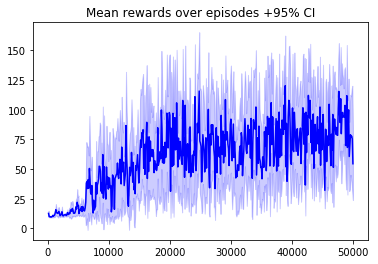

In [32]:
runner.plot(mode='ci')

## Future Directions

I am as of yet unsure as to why the learning so unstable for this agent. Some possibilities include:
1. Bad hyper-parameters
2. Overfitting of the Q-function
3. Exploding co-efficients
4. DQN might simply be too unstable

In [28]:
K.clear_session()